<table>
<tr style="background-color:#FFFFFF;">
<td width=20%>
    <table>
        <tr><img style="text-align:left" src="./img/logo_uga.jpeg" width="80" ></br></a>
        </tr> 
    </table>
</td>
<td><center><h1>Lab 8 : Safe Machine Learning via superquantile optimization</h1></center></td>
<td width=15%>
    <table>
        <tr><img src="./img/logo_uw.png" width="300"></br></a>
        </tr>
    </table>
</td>
</tr>
<tr>
<td style="text-align:left">
    <table>
            <tr><a href="https://yassine-laguel.github.io" style="font-size: 15px ">Yassine Laguel <br></a></tr>
    </table>       
<td style="text-align:center">DATA 558, Spring 2021</td>
<td style="text-align:right">
    <table>
    <tr> <a href="https://ronakdm.github.io" style="font-size: 15px">Ronak Mehta<br></a> </tr>
    <tr> <a href="https://sites.stat.washington.edu/people/alecgt/" style="font-size: 15px">Alec Grieves-Tunell <br></a> </tr>
    <tr> <a href="https://krishnap25.github.io" style="font-size: 15px">Krishna Pillutla </br></a> </tr>
    </table>
    </td> 
</tr>
</table>

In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder, label_binarize
from sklearn.linear_model import LinearRegression
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

## Overview

In this lab, we will:
- Discuss metrics to quantify robustness for both classification and regression.
- Investigate these metrics on two toy problems.
- Learn how to train superquantile-based models for classification and regression.
- Quantify and visualize the impact of these models on robustness.
- Apply these tools to real datasets. 


## 1. Motivations

Distributional robustness can be measured in two ways:

- Better performance for worst-case outcomes.
- Better performances for pessimistic distributional shifts.

### 1.1 Illustration on a regression task

Let us consider a linear regression task on the following synthetic training dataset:

$$
    y_i = \alpha x_i  + \beta + \varepsilon_i \quad \text{ with } \varepsilon_i = \beta\; \varepsilon_{1} + (1-\beta) \varepsilon_{
    2}
$$

where 
- $x_i \in \mathbb{R}$ is sampled from a uniform distribution on $[0,100]$.
- $\varepsilon_{1}$ and $\varepsilon_{2}$ follow a normal law with respective parameters $(\mu_1, \sigma_1) = (0, 1)$ and $(\mu_2, \sigma_2) = (10, 3)$.
- $\beta$ follows a Bernouilli distribution with parameter $p=0.8$.
- $\alpha = 0.2,\; \beta=1.$

Let's visualize our dataset together with performance of a classical linear model

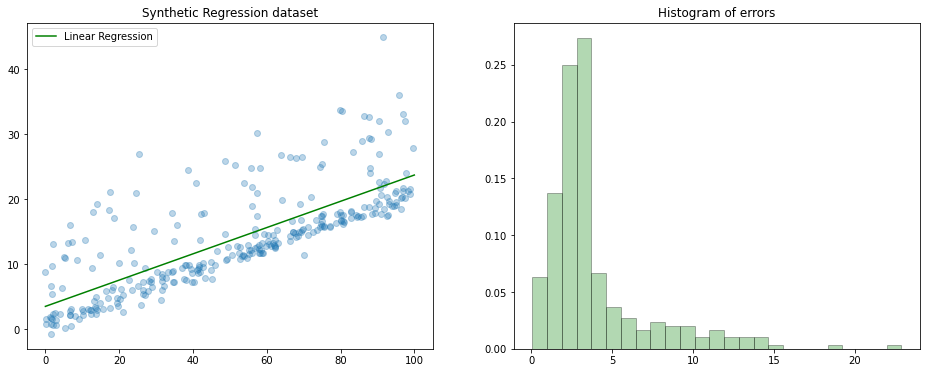

In [54]:
def generate_regression_data(seed=1, size=300):
    
    np.random.seed(seed)
    beta = 1.0
    alpha = 0.2
    x = np.random.uniform(high=100,size=size)
    eps1 = np.random.normal(loc=0.0, scale=1.0, size=size)
    eps2 = np.random.normal(loc=10.0, scale=5.0, size=size)
    beta = np.random.binomial(1, 0.7, size=size)
    
    noise = beta * eps1 + (1-beta) * eps2 
    y = beta * np.ones(size) + alpha * x + noise
    
    return x, y

def plot_synthetic_regression(x, y):
    
    formatted_x = x.reshape(-1, 1)
    lr = LinearRegression().fit(formatted_x, y)
    errors = np.abs(y - lr.predict(formatted_x))
    
    fig, axes = plt.subplots(1, 2, figsize = (16, 6))
    graph = axes[0]
    graph.title.set_text('Synthetic Regression dataset')
    graph.scatter(x, y, alpha=0.3)
    t = np.array([0, 100]).reshape(-1,1)
    ft = lr.predict(t)
    graph.plot(t, ft, color='g', label='Linear Regression')
    graph.legend()
         
    hist = axes[1]
    hist.title.set_text('Histogram of errors')
    
#     kwargs = dict(histtype='bar', ec='black', alpha=0.3, bins=bins)
    weights = np.ones_like(errors)/len(errors)
    hist.hist(errors, weights=weights, color = "g", bins=25, alpha=0.3, histtype='bar', ec='black')

    plt.show()
    
x, y = generate_regression_data(seed=1)
plot_synthetic_regression(x, y)

**Exercise 1.1**: Comment the graphs. 

Let us compute a few metrics to evaluate the worst-case performances of our linear model.

**Exercise 1.2**: Implement the quantile and superquantile functions respectively defined as:

$$
\begin{align}
Q_p(U) &= \inf\{t \in \mathbb{R}, \mathbb{P}[U \leq t] \geq p\} \\
\text{and }\;\; \bar{Q}_p(U) &= \frac{1}{1-p} \int_{p'=p}^1 Q_{p'}(U) dp'
\end{align}
$$

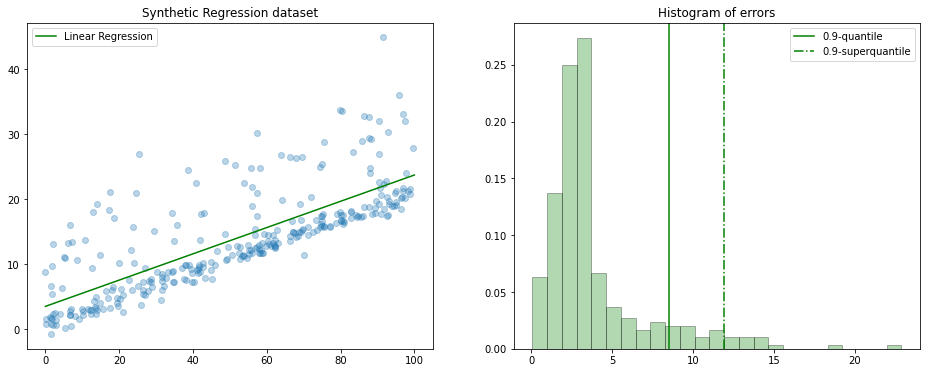

In [55]:
from spqr.measures import quantile, superquantile

def quantile_function(p, U):
    ### <YOUR_CODE_HERE>
    quantile = None
    ###
    return quantile

def superquantile_function(p, U):
    ### <YOUR_CODE_HERE>
    superquantile = None
    ###
    return superquantile

# Answers
def quantile_function(p, U):
    return quantile(p, U)
def superquantile_function(p, U):
    return superquantile(p, U)

def plot_synthetic_regression_with_metrics(x, y):
    
    formatted_x = x.reshape(-1, 1)
    lr = LinearRegression().fit(formatted_x, y)
    errors = np.abs(y - lr.predict(formatted_x))
    p=0.9
    q_p = quantile_function(p, errors)
    superq_p = superquantile_function(p, errors)
    
    fig, axes = plt.subplots(1, 2, figsize = (16, 6))
    
    graph = axes[0]
    graph.title.set_text('Synthetic Regression dataset')
    graph.scatter(x, y, alpha=0.3)
    t = np.array([0, 100]).reshape(-1,1)
    ft = lr.predict(t)
    graph.plot(t, ft, color='g', label='Linear Regression')
    graph.legend()
         
    hist = axes[1]
    hist.title.set_text('Histogram of errors')
    weights = np.ones_like(errors)/len(errors)
    hist.hist(errors, weights=weights, color = "g", bins=25, alpha=0.3, histtype='bar', ec='black')
    hist.axvline(q_p, linestyle='-', color='g', label=str(p) + '-quantile')
    hist.axvline(superq_p, linestyle='-.', color='g', label=str(p) + '-superquantile')
    
    hist.legend()

    plt.show()

plot_synthetic_regression_with_metrics(x, y)

**Exercise 1.3**: Given the above distribution of errors, computes the following metrics and report them in a table:
- the minimum value 
- the mean value
- the $p$-quantile for $p\in \{0.0, 0.2, 0.5, 0.7, 0.9, 0.99\} $ 
- the $p$-superquantile for $p\in \{0.0, 0.2, 0.5, 0.7, 0.9, 0.99\}$ 

Comment the results. 

In [56]:
### <YOUR_CODE_HERE>

**Your comments:**

### 1.2 Illustration on a classification task

Let us now consider a binary classification task on a real dataset: the Australian credit approcal [dataset](https://archive.ics.uci.edu/ml/datasets/statlog+(australian+credit+approval) from the UCI Repository. 

In [57]:
from course_utils import fetch_australian_dataset
x_tr, y_tr, x_te, y_te = fetch_australian_dataset(seed=1)

**Exercice 1.3:** Evaluate first the proportion of each class for both the training set and the testing set.

In [58]:
### <YOUR_CODE_HERE>

# Solution:
classes, counts = np.unique(y_te, return_counts=True)
print(classes)
print(counts)

classes, counts = np.unique(y_tr, return_counts=True)
print(classes)
print(counts)

[0 1]
[133 109]
[0 1]
[250 198]


A popular linear model to train for such tasks is the [Logistic Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html). It consists in minizing the loss:

$$
        \min_{w, c} \frac{1}{n} \sum_{i=1}^{n} \log(\exp(-y_i(X_i^\top w + c)) + 1) + \frac{1}{nC} \|w\|_2^2
$$


Let us start by training a logistic regression model on the training sample and evaluate its performances on the training set and the testing set:

In [59]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score

clf = LogisticRegression(fit_intercept=False).fit(x_tr, y_tr)

y_hat_tr = clf.predict(x_tr)
y_hat_te = clf.predict(x_te)

print("Train accuracy score : {acc:.3f}".format(acc=accuracy_score(y_tr, y_hat_tr)))
print("Train precision score : {acc:.3f}".format(acc=precision_score(y_tr, y_hat_tr)))

print("Test accuracy score : {acc:.3f}".format(acc=accuracy_score(y_te, y_hat_te)))
print("Test precision score : {acc:.3f}".format(acc=precision_score(y_te, y_hat_te)))

Train accuracy score : 0.875
Train precision score : 0.851
Test accuracy score : 0.868
Test precision score : 0.853


The model produced generalizes well on the observed testing set. We may now investigate performances of this model for a sequence of distributional shifts on the testing set. We implement a python function `shift` to rebalance arbitrarily the proportion of each class in the testing dataset.

In [60]:
from course_utils import get_data_class
def shift(x, y, new_proportion, seed=1):
    generator = np.random.default_rng(seed)
    classes, counts = np.unique(y, return_counts=True)
    max_size = np.min(counts)
    
    x_0, y_0 = get_data_class(x, y, 0)
    x_1, y_1 = get_data_class(x, y, 1)
    subsampled_index_0 = generator.choice(np.arange(x_0.shape[0]), size=np.ceil(new_proportion * max_size).astype(np.int64),
                                          replace=False)
    subsampled_index_1 = generator.choice(np.arange(x_1.shape[0]), size=np.ceil((1.0-new_proportion) * max_size).astype(np.int64),
                                          replace=False)
    x_0 = x_0[subsampled_index_0]
    y_0 = y_0[subsampled_index_0]
    x_1 = x_1[subsampled_index_1]
    y_1 = y_1[subsampled_index_1]
    
    new_x = np.concatenate([x_0, x_1])
    new_y = np.concatenate([y_0, y_1])

    shuffled_index = generator.permutation(np.arange(new_x.shape[0]))
    new_x = new_x[shuffled_index]
    new_y = new_y[shuffled_index]

    return new_x, new_y

**Exercice 1.4:** Evaluate the performances of the linear model on several distributionnal shifts of the testing set. Comment.

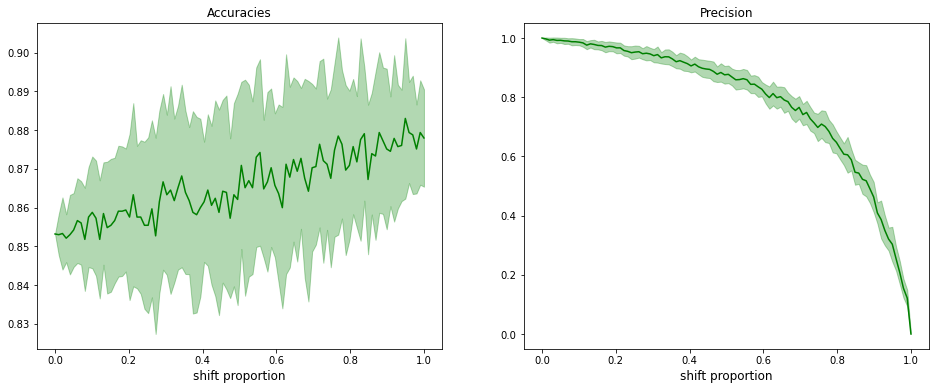

In [61]:
### <YOUR_CODE_HERE>

# Solution
# lst_prop = np.linspace(0,1, num=100)
lst_prop = np.linspace(0,1.0, num=100)

lst_accuracy = []
lst_min_accuracy = []
lst_max_accuracy = []

lst_precision = []
lst_min_precision = []
lst_max_precision = []

n_seeds = 30

for prop in lst_prop:
    temp_acc = []
    temp_prec = []
    
    for seed in range(n_seeds):
        shifted_x, shifted_y = shift(x_te, y_te, prop, seed=seed)
        y_hat = clf.predict(shifted_x)
        temp_acc.append(accuracy_score(shifted_y, y_hat))
        temp_prec.append(precision_score(shifted_y, y_hat))
    max_acc = np.mean(temp_acc) + np.std(temp_acc)
    min_acc = np.mean(temp_acc) - np.std(temp_acc)
    mean_acc = np.mean(temp_acc)
    max_prec = np.mean(temp_prec) + np.std(temp_prec)
    min_prec = np.mean(temp_prec) - np.std(temp_prec)
    mean_prec = np.mean(temp_prec)
    
    
    lst_accuracy.append(mean_acc)
    lst_min_accuracy.append(min_acc)
    lst_max_accuracy.append(max_acc)

    lst_precision.append(mean_prec)
    lst_min_precision.append(min_prec)
    lst_max_precision.append(max_prec)

fig, axes = plt.subplots(1, 2, figsize = (16, 6))

graph1 = axes[0]
graph1.title.set_text('Accuracies')
weights = np.ones_like(lst_accuracy)/len(lst_accuracy)
graph1.plot(lst_prop, lst_accuracy, color = "g", alpha=1.0)
graph1.fill_between(lst_prop, lst_min_accuracy, lst_max_accuracy, color = "g", alpha=0.3)
graph1.set_xlabel('shift proportion', fontsize=12)

graph2 = axes[1]
graph2.title.set_text('Precision')
weights = np.ones_like(lst_precision)/len(lst_precision)
graph2.plot(lst_prop, lst_precision, color = "g",  alpha=1.0)
graph2.fill_between(lst_prop, lst_min_precision, lst_max_precision, color = "g", alpha=0.3)
graph2.set_xlabel('shift proportion', fontsize=12)

plt.show()

**Exercise 1.5** Comment your results

## 2. The toolbox `spqr`

`sqpr` is a python toolbox, built on top of `sklearn` and aimed at providing optimization first order convex algorithms for the minimization of superquantile based measures. For more information we refer to its [online documentation](https://yassine-laguel.github.io/spqr/).

In this tutorial, we'll focus on how to use `SPQR` to perform distributionally robust regression and classification tasks. For that purpose, the toolbox provides users with two estimators:
- `DRLinearRegression`, for regression, which solves:

$$
\min_{w, c} \bar{Q}_p((Y - w_\top X - c)) + \frac{1.}{nC} \|w\|_2^2
$$

- `DRLogisticRegression` which solves:
$$
\min_{w, c} \bar{Q}_p(\log(\exp(-Y(X^\top w + c)) + 1)) + \frac{1.}{nC} \|w\|_2^2
$$

### 2.1 $\ell_2$-regression with `spqr`

Let's instantiate a `DRLinearRegression` object to fit our previous regression dataset. 

**Exercise 2.1:** Implement a distributionnaly robust linear regression on the previous regression dataset and compare its performance against the classical linear regression. 

In [62]:
from spqr import DRLinearRegression

def plot_synthetic_regression_with_metrics(x, y):
    
    formatted_x = x.reshape(-1, 1)
    lr = LinearRegression().fit(formatted_x, y)
    errors = np.abs(y - lr.predict(formatted_x))
    p=0.9
    q_p = quantile_function(p, errors)
    superq_p = superquantile_function(p, errors)
    
    regressor = DRLinearRegression(p=0.9, fit_intercept=True)
    regressor.fit(formatted_x, y)
    errors2 = np.abs(y - regressor.predict(formatted_x).ravel())
    p=0.9
    q_p2 = quantile_function(p, errors2)
    superq_p2 = superquantile_function(p, errors2)

    fig, axes = plt.subplots(1, 2, figsize = (16, 6))
    
    graph = axes[0]
    graph.title.set_text('Synthetic Regression dataset')
    graph.scatter(x, y, alpha=0.3)
    t = np.array([0, 100]).reshape(-1,1)
    ft = lr.predict(t)
    ft2 = regressor.predict(t)
    graph.plot(t, ft, color='g', label='Linear Regression')
    graph.plot(t, ft2, color='r', label='Superquantile Linear Regression')
    graph.legend()
         
    hist = axes[1]
    hist.title.set_text('Histogram of errors')
    weights = np.ones_like(errors)/len(errors)
    weights2 = np.ones_like(errors2)/len(errors2)
    hist.hist(errors, weights=weights, color = "g", bins=25, alpha=0.3, histtype='bar', ec='black')
    hist.hist(errors2, weights=weights2, color = "r", bins=25, alpha=0.3, histtype='bar', ec='black')
    hist.axvline(q_p, linestyle='-', color='g', label=str(p) + '-quantile')
    hist.axvline(superq_p, linestyle='-.', color='g', label=str(p) + '-superquantile')
    hist.axvline(q_p2, linestyle='-', color='r', label=str(p) + '-quantile')
    hist.axvline(superq_p2, linestyle='-', color='r', label=str(p) + '-superquantile')
    
    hist.legend()
    
    plt.show()


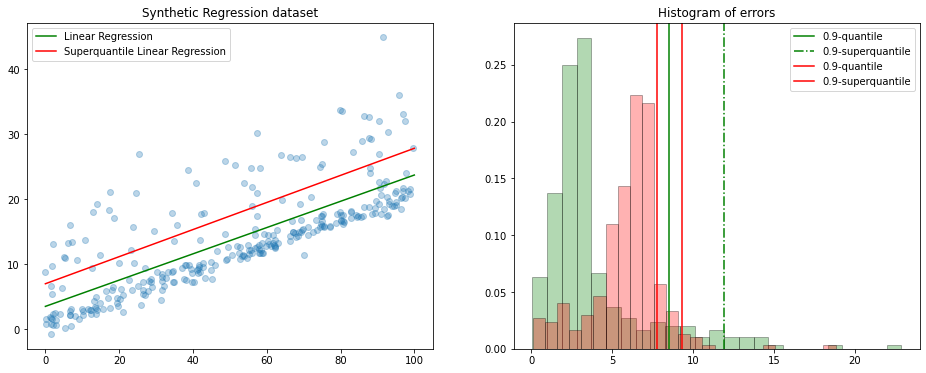

In [63]:
x, y = generate_regression_data(seed=1)
plot_synthetic_regression_with_metrics(x, y)

### 2.2 Logistic regression with `spqr`

In [64]:
from spqr import DRLogisticRegression


super_clf = DRLogisticRegression(p=0.8, fit_intercept=False)
super_clf.fit(x_tr, y_tr) # TODO: let fit return the classifier

y_hat_tr = super_clf.predict(x_tr)
y_hat_te = super_clf.predict(x_te)

print("Train accuracy score : {acc:.3f}".format(acc=accuracy_score(y_tr, y_hat_tr)))
print("Train precision score : {acc:.3f}".format(acc=precision_score(y_tr, y_hat_tr)))

print("Test accuracy score : {acc:.3f}".format(acc=accuracy_score(y_te, y_hat_te)))
print("Test precision score : {acc:.3f}".format(acc=precision_score(y_te, y_hat_te)))

Train accuracy score : 0.873
Train precision score : 0.837
Test accuracy score : 0.851
Test precision score : 0.802


**Exercise 2.1:** Compare the performances of the superquantile model with the risk-neutral model on a sequence of distributional shifts. Comment.

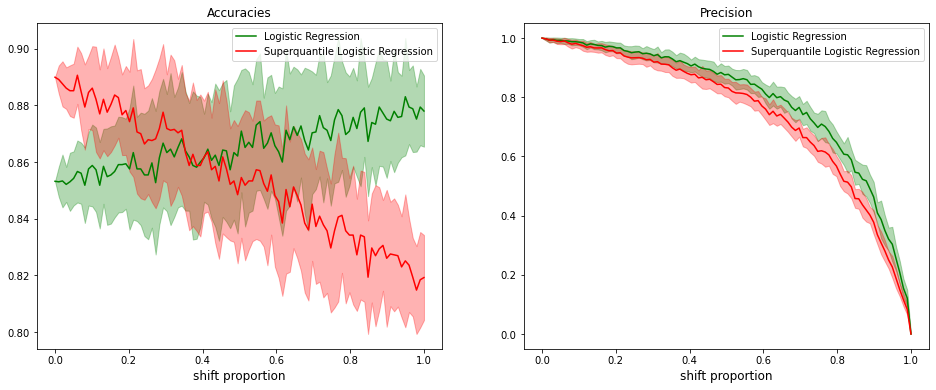

In [65]:
lst_prop = np.linspace(0.0,1.0, num=100)

lst_accuracy = []
lst_min_accuracy = []
lst_max_accuracy = []

lst_precision = []
lst_min_precision = []
lst_max_precision = []

lst_accuracy2 = []
lst_min_accuracy2 = []
lst_max_accuracy2 = []

lst_precision2 = []
lst_min_precision2 = []
lst_max_precision2 = []

for prop in lst_prop:
    temp_acc = []
    temp_prec = []
    
    temp_acc2 = []
    temp_prec2 = []
    
    for seed in range(n_seeds):
        shifted_x, shifted_y = shift(x_te, y_te, prop, seed=seed)
        y_hat = clf.predict(shifted_x)
        y_hat2 = super_clf.predict(shifted_x)
        temp_acc.append(accuracy_score(shifted_y, y_hat))
        temp_prec.append(precision_score(shifted_y, y_hat))
        temp_acc2.append(accuracy_score(shifted_y, y_hat2))
        temp_prec2.append(precision_score(shifted_y, y_hat2))

    max_acc = np.mean(temp_acc) + np.std(temp_acc)
    min_acc = np.mean(temp_acc) - np.std(temp_acc)
    mean_acc = np.mean(temp_acc)
    max_prec = np.mean(temp_prec) + np.std(temp_prec)
    min_prec = np.mean(temp_prec) - np.std(temp_prec)
    mean_prec = np.mean(temp_prec)
    

    max_acc2 = np.mean(temp_acc2) + np.std(temp_acc2)
    min_acc2 = np.mean(temp_acc2) - np.std(temp_acc2)
    mean_acc2 = np.mean(temp_acc2)
    max_prec2 = np.mean(temp_prec2) + np.std(temp_prec2)
    min_prec2 = np.mean(temp_prec2) - np.std(temp_prec2)
    mean_prec2 = np.mean(temp_prec2)
    
    lst_accuracy.append(mean_acc)
    lst_min_accuracy.append(min_acc)
    lst_max_accuracy.append(max_acc)
    lst_precision.append(mean_prec)
    lst_min_precision.append(min_prec)
    lst_max_precision.append(max_prec)
    
    lst_accuracy2.append(mean_acc2)
    lst_min_accuracy2.append(min_acc2)
    lst_max_accuracy2.append(max_acc2)
    lst_precision2.append(mean_prec2)
    lst_min_precision2.append(min_prec2)
    lst_max_precision2.append(max_prec2)
    
fig, axes = plt.subplots(1, 2, figsize = (16, 6))

graph1 = axes[0]
graph1.title.set_text('Accuracies')
graph1.plot(lst_prop, lst_accuracy, color = "g", alpha=1.0, label='Logistic Regression')
graph1.plot(lst_prop, lst_accuracy2, color = "r", alpha=1.0, label='Superquantile Logistic Regression')
graph1.fill_between(lst_prop, lst_min_accuracy, lst_max_accuracy, color = "g", alpha=0.3)
graph1.fill_between(lst_prop, lst_min_accuracy2, lst_max_accuracy2, color = "r", alpha=0.3)
graph1.set_xlabel('shift proportion', fontsize=12)
graph1.legend()

graph2 = axes[1]
graph2.title.set_text('Precision')
graph2.plot(lst_prop, lst_precision, color = "g",  alpha=1.0, label='Logistic Regression')
graph2.plot(lst_prop, lst_precision2, color = "r",  alpha=1.0, label='Superquantile Logistic Regression')
graph2.fill_between(lst_prop, lst_min_precision, lst_max_precision, color = "g", alpha=0.3)
graph2.fill_between(lst_prop, lst_min_precision2, lst_max_precision2, color = "r", alpha=0.3)
graph2.set_xlabel('shift proportion', fontsize=12)
graph2.legend()

plt.show()

## 3. The iWildCam Challenge Dataset

In this section, we will not introduce any new content, but rather work through the method on a much more realistic example than before

The [iWildCam](https://wilds.stanford.edu/datasets/#iwildcam) dataset contains images of various elements of nature, such as animals and landscapes. The original number of data points is ~130,000 training examples, ~10,000 validation examples, and ~40,000 test examples. There are a total of 182 training classes, not all of which are present in the validation and test sets. These are captured by camera traps in various wildlife habitats. There is drastic variation in illumination, camera angle, background, vegetation, color, and relative animal frequencies, which results in models generalizing poorly to new camera trap deployments.

**Exercise 3.1**: Print the sorted counts of the classes in the training set. What do you notice? (*Hint:* use `numpy.unique`.)

In [66]:
import numpy as np

y_train_full = np.load("data/y_train.npy")

## <YOUR CODE HERE>
classes, counts = np.unique(y_train_full, return_counts=True)
print(np.sort(counts))
##

[    1     1     1     1     1     1     1     1     1     1     1     2
     2     2     2     2     2     3     3     3     3     3     3     3
     3     3     3     3     3     3     3     3     3     4     4     4
     5     5     6     6     6     6     6     6     6     6     6     6
     6     7     7     7     8     8     8     9     9     9     9     9
     9     9     9    10    10    10    10    11    12    12    12    12
    12    12    13    13    13    14    15    15    15    15    15    18
    18    19    20    20    21    21    23    24    25    28    29    29
    29    30    30    32    36    38    38    39    44    46    48    50
    55    60    60    62    70    73    75    80    80    80    81    87
    92   100   100   102   106   108   110   117   128   136   146   158
   161   180   190   194   200   201   243   290   350   367   380   433
   450   457   459   531   538   605   684   716   730   771   865   904
   949   977  1042  1150  1168  1246  1428  1444  1

While the original dataset uses images, we have featurized the dataset into lower-dimensional real vectors. Additionally, we have subsampled the data significantly, such that that there are fewer classes, and more data per class. Observe the shapes of the reduced data matrices.

In [67]:
X_train = np.load("data/X_train_reduced.npy")
y_train = np.load("data/y_train_reduced.npy")
X_val = np.load("data/X_val_reduced.npy")
y_val = np.load("data/y_val_reduced.npy")
X_test = np.load("data/X_test_reduced.npy")
y_test = np.load("data/y_test_reduced.npy")

print("X train shape:", X_train.shape)
print("X val shape:", X_val.shape)
print("X test shape:", X_test.shape)

classes, counts = np.unique(y_train, return_counts=True)
print(np.sort(counts))

X train shape: (9204, 73)
X val shape: (4376, 73)
X test shape: (4629, 73)
[  52   60   62   63   65   73   76   81   82   90   95  114  116  122
  124  125  141  144  153  196  223  226  244  251  277  293  295  324
  552  802 3683]


While there this reduced dataset is easier to handle both statistically and computationally, there is significant class imbalance still. We will try downsampling the majority class.

**Exercise 3.2**: Downsample the majority class of `y_train` by a factor of 3.

In [68]:
np.random.seed(123)

## <YOUR CODE HERE>
# classes, counts = np.unique(y_train, return_counts=True)
# print(classes)
# print(counts)
n_train = len(y_train)

maj_idx = np.arange(n_train)[y_train==0]
sub_idx = np.random.choice(maj_idx, 2 * len(maj_idx) // 3, replace=False)
idx = np.delete(np.arange(n_train), sub_idx)

X_tr = X_train[idx]
y_tr = y_train[idx]
##

Here, we store a map from class to index, as not all classes are present in the validation and test set. We also show the performance of the "chance" classifier, that predicts the value of the largest class every time.

In [69]:
class_to_idx = {}
for i, class_ in enumerate(classes):
    class_to_idx[class_] = i

classes, counts = np.unique(y_tr, return_counts=True)
print(counts)
print("Chance:", counts.max() / counts.sum())

[1228  293  324  244   73  277  153   52  124   90  116  223  114  141
   81  144   60  125   62   63  295  226  802  552  122  196   76   95
  251   65   82]
Chance: 0.18195288190843087


Next, we get baseline performance using logistic regression.

In [70]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

np.random.seed(123)

C_range = np.logspace(-5, 0, 5)

best_acc = -1
best_C = None
lr = None
try:
    for C in C_range:
        print("Evaluating C = %0.5f..." % C)
        model = LogisticRegression(C=C, solver='liblinear').fit(X_tr, y_tr)
        
        acc = accuracy_score(y_val, model.predict(X_val))
        print("\t Accuracy:", acc)
        if acc > best_acc:
            best_acc = acc
            best_C = C
            lr = model

    print("Best C:", best_C)
    print("Best accuracy:", best_acc)
except KeyboardInterrupt:
    print("Graceful Exit")

Evaluating C = 0.00001...
	 Accuracy: 0.4515539305301645
Evaluating C = 0.00018...
	 Accuracy: 0.5509597806215722
Evaluating C = 0.00316...
	 Accuracy: 0.5393053016453382
Evaluating C = 0.05623...
	 Accuracy: 0.5178244972577697
Evaluating C = 1.00000...
	 Accuracy: 0.49885740402193784
Best C: 0.00017782794100389227
Best accuracy: 0.5509597806215722


This is significantly better than chance! Now, we will compute a few metrics on the test set. Of interest to us is the performance of a classifier at the *tail of its loss*. We compute both the accuracy and $p$-th superquantile for various values of $p$ on the test set for the logistic regression trained earlier.

In [71]:
from spqr.measures import superquantile

def compute_metrics(y_proba, y_true, ps):
    
    # Test accuracy.
    y_pred = np.argmax(y_proba, axis=1)
    acc = accuracy_score(y_true, y_pred)

    # Log losses.
    n = len(y_true)
    losses = np.zeros(n)
    for i in range(n):
        losses[i] = -np.log(y_proba)[i, class_to_idx[y_true[i]]]

    # sq_loss = [sq(losses, p) for p in ps]
    sq_loss = [superquantile(p, losses) for p in ps]
    
    return acc, sq_loss, losses

In [72]:
ps = [0.5, 0.75, 0.8, 0.9, 0.95, 0.99]

In [73]:
lr_acc, lr_sq_loss, lr_losses = compute_metrics(lr.predict_proba(X_test), y_test, ps)

In [74]:
from spqr import DRLogisticRegression

def softmax(Z):
    np.clip(Z, -10, 10)
    norm_constant = np.exp(Z).sum(axis=1).reshape(-1, 1)
    return np.exp(Z) / norm_constant

def predict_proba(model, x):
    """ Gives a prediction of x
            :param ``numpy.array`` x: input whose label is to predict
            :return:  value of the prediction
    """
    self = model
    formatted_x = np.ones((x.shape[0], self.n_features + self.fit_intercept))
    formatted_x[:, self.fit_intercept:] = x
    casted_sol = np.reshape(self.solution, (self.n_features + self.fit_intercept, self.n_classes))
    probas = softmax(np.dot(formatted_x, casted_sol))

    return probas

Next, we apply the the Distributionally Robust Logistic Regression (DRLR) method to the same data, with $p = 0.8$, and a hyperparameter search over $mu$ (an optimization parameter).

In [75]:
mus = [0.1, 1, 10, 100, 1000]
lmbda = 2 / best_C
p = 0.8

best_mu = -1
best_acc = -1
try:
    for mu in mus:

        print("Evaluating mu = %f..." % mu)

        model = DRLogisticRegression(p=p, mu=mu, lmbda=lmbda)
        model.fit(X_tr, y_tr)

        acc = accuracy_score(y_val, model.predict(X_val))
        print("\t Accuracy:", acc)
        if acc > best_acc:
            best_acc = acc
            best_mu = mu
            drlr = model

    print("Best mu:", best_mu)
    print("Best accuracy:", best_acc)
except KeyboardInterrupt:
    print("Graceful Exit")

Evaluating mu = 0.100000...
	 Accuracy: 0.06535648994515539
Evaluating mu = 1.000000...
	 Accuracy: 0.11928702010968921
Evaluating mu = 10.000000...
	 Accuracy: 0.14693784277879343
Evaluating mu = 100.000000...
	 Accuracy: 0.13322669104204754
Evaluating mu = 1000.000000...
	 Accuracy: 0.13208409506398539
Best mu: 10
Best accuracy: 0.14693784277879343


Note that the accuracy above is not a good as LR, but it is not what we are optimizing for. Instead, we will observe the tail of the losses, and ensure that the *largest ones are not too large*.

In [76]:
drlr_acc, drlr_sq_loss, drlr_losses = compute_metrics(predict_proba(drlr, X_test), y_test, ps)

Finally, plot the $p$-th superquantile of the losses on the test set, as a function of $p$.

LR Accuracy: 0.33722186217325556
DRLR Accuracy: 0.2914236336141715


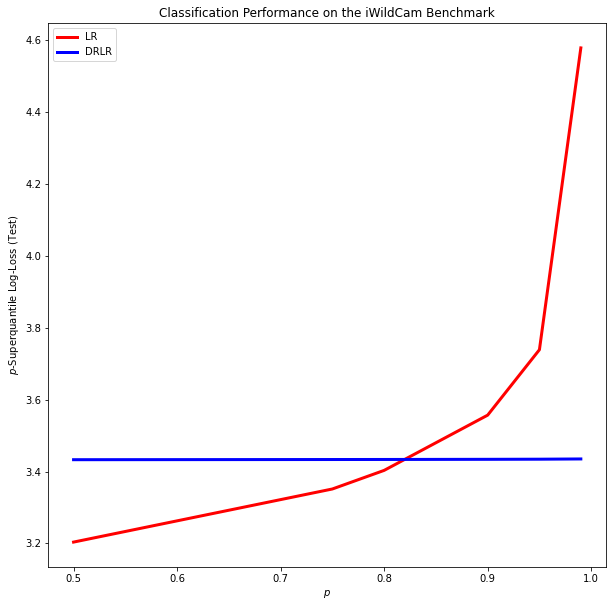

In [77]:
import matplotlib.pyplot as plt

print("LR Accuracy:", lr_acc)
print("DRLR Accuracy:", drlr_acc)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))

ax.plot(ps, lr_sq_loss, color="red", linewidth=3, label="LR")
ax.set_label("p")
ax.plot(ps, drlr_sq_loss, color="blue", linewidth=3, label="DRLR")
ax.legend()
ax.set_xlabel(r"$p$")
ax.set_ylabel(r"$p$-Superquantile Log-Loss (Test)")
ax.set_title("Classification Performance on the iWildCam Benchmark")

plt.show()

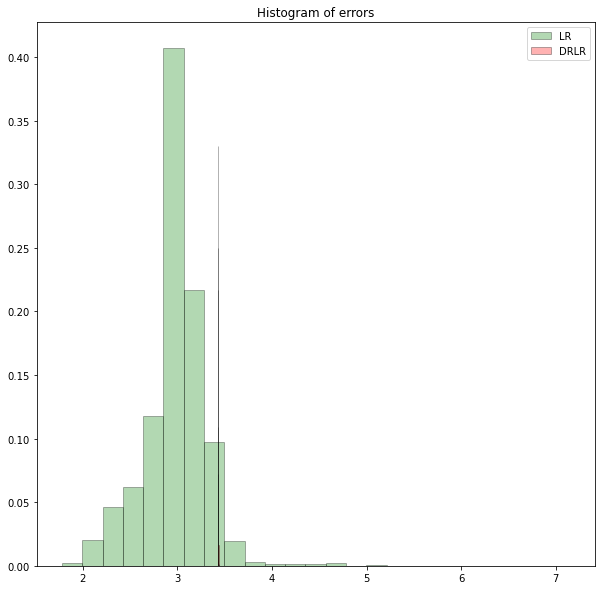

In [78]:
fig, hist = plt.subplots(1, 1, figsize=(10, 10))
hist.title.set_text('Histogram of errors')

errors = lr_losses
errors2 = drlr_losses

weights = np.ones_like(errors)/len(errors)
weights2 = np.ones_like(errors2)/len(errors2)
hist.hist(errors, weights=weights, color = "g", bins=25, alpha=0.3, histtype='bar', ec='black', label="LR")
hist.hist(errors2, weights=weights2, color = "r", bins=10, alpha=0.3, histtype='bar', ec='black', label="DRLR")
hist.legend()

plt.show()